In [ ]:
import keras
from keras import layers
import numpy as np

original_dim = 28 * 28
intermediate_dim = 128
intermediate_dim2 = 128
# intermediate_dim3 = 32
latent_dim = 25          #30 #50 #5

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim2, activation='relu')(h)
# h3 = layers.Dense(intermediate_dim3, activation='relu')(h2)
z_mean = layers.Dense(latent_dim)(h2)

z_log_sigma = layers.Dense(latent_dim)(h2)

# z_mean = layers.Dense(latent_dim)(h)

# z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)

(None, 25)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
# x = layers.Dense(intermediate_dim3, activation='relu')(latent_inputs)
x2 = layers.Dense(intermediate_dim2, activation='relu')(latent_inputs)
x3 = layers.Dense(intermediate_dim, activation='relu')(x2)
outputs = layers.Dense(original_dim, activation='sigmoid')(x3)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          100480      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 25)           3225        ['dense_1[0][0]']                
                                                                                            

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

In [ ]:

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32)
        #validation_data=(x_test, x_test))

x_decoded = vae.predict(x_train)

Epoch 1/50
1875/1875 [==============================] - 19s 9ms/step - loss: 127.1687
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 93.0894
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 86.3878
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 82.7640
Epoch 5/50
1875/1875 [==============================] - 8s 5ms/step - loss: 80.4177
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 78.8383
Epoch 7/50
1875/1875 [==============================] - 8s 5ms/step - loss: 77.6702
Epoch 8/50
1875/1875 [==============================] - 8s 5ms/step - loss: 76.6271
Epoch 9/50
1875/1875 [==============================] - 9s 5ms/step - loss: 75.9220
Epoch 10/50
1875/1875 [==============================] - 8s 5ms/step - loss: 75.3916
Epoch 11/50
1875/1875 [==============================] - 9s 5ms/step - loss: 74.9506
Epoch 12/50
1875/1875 [==============================] - 9s 5ms/step - l

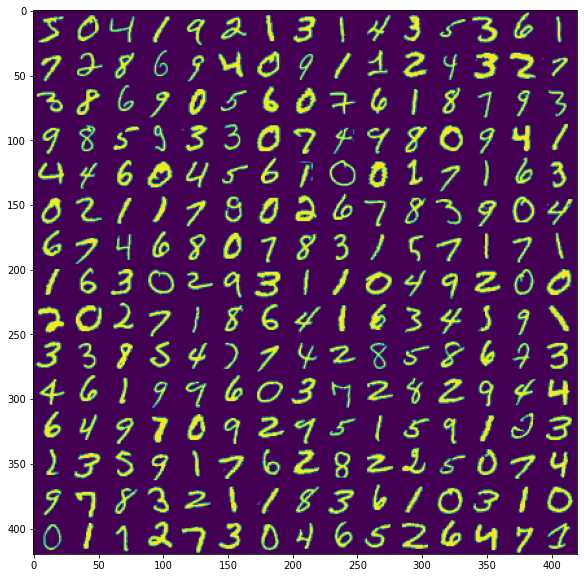

In [ ]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_train[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

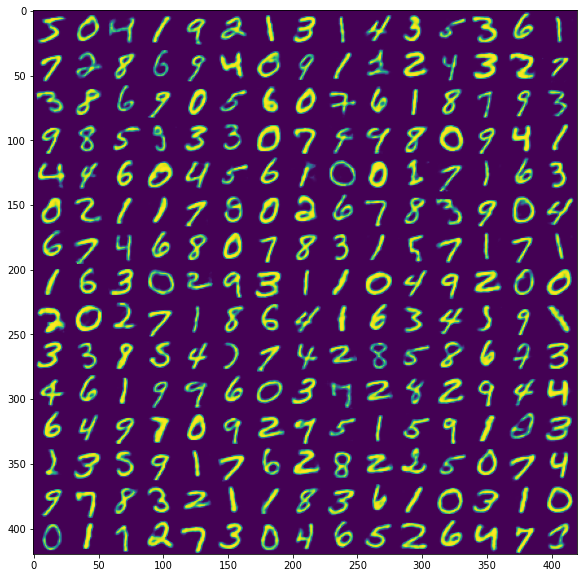

In [ ]:
import matplotlib.pyplot as plt
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k = k +1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
z_zz = encoder.predict(x_train)
print (z_zz[2].shape)
print (z_zz[2][0].shape)

(60000, 25)
(25,)


In [ ]:
# x_decoded = decoder.predict(z_zz[2]+0.8)             #0.01 #0.4  #0.8  
x_decoded = decoder.predict(z_zz[0]+z_zz[1] * 0.9)    #0.01  #0.2 #0.4  #0.8  #0.99

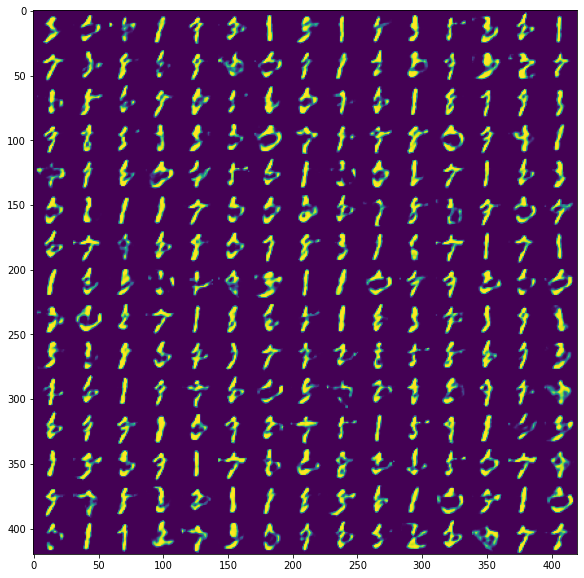

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #z_sample = np.array([[xi, yi]])
        #x_decoded = decoder.predict(z_sample)
        
        digit = x_decoded[k].reshape(digit_size, digit_size)
        k=k+1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()